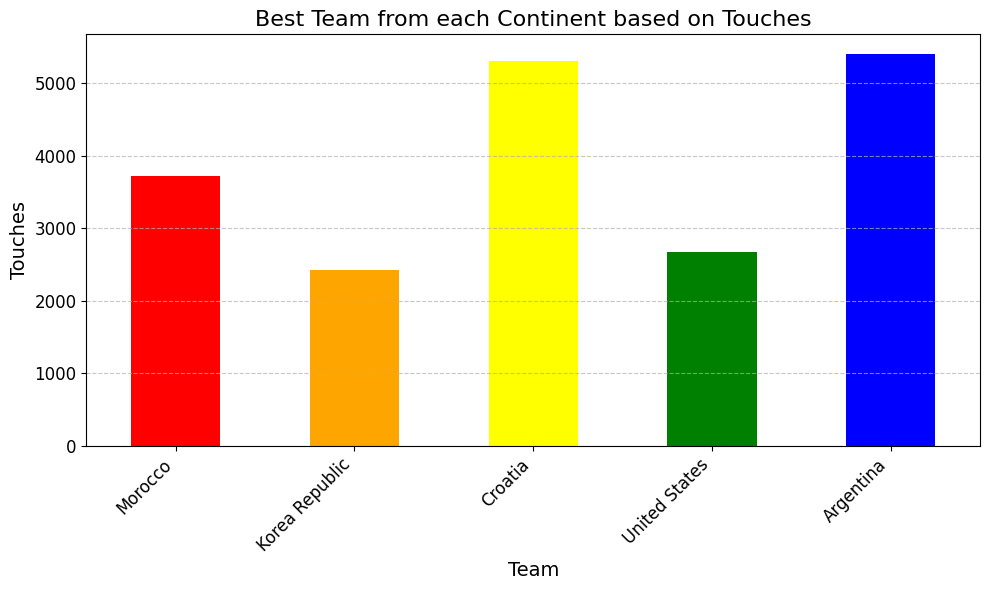

Team With Most Touches:  Argentina
Number of touches: 5408


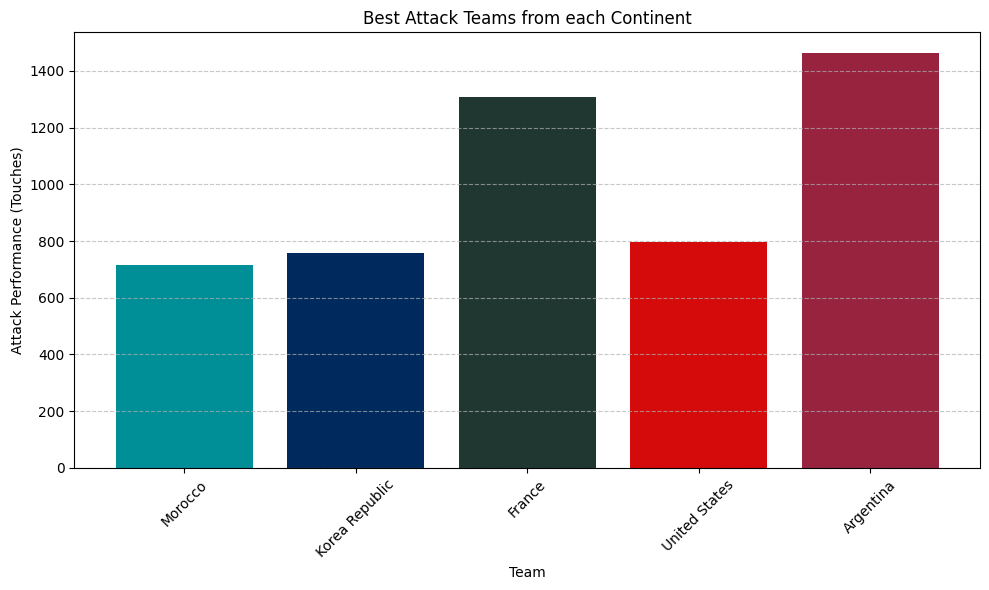

Team with Most Attack Touches: Argentina
Number of touches:  1463


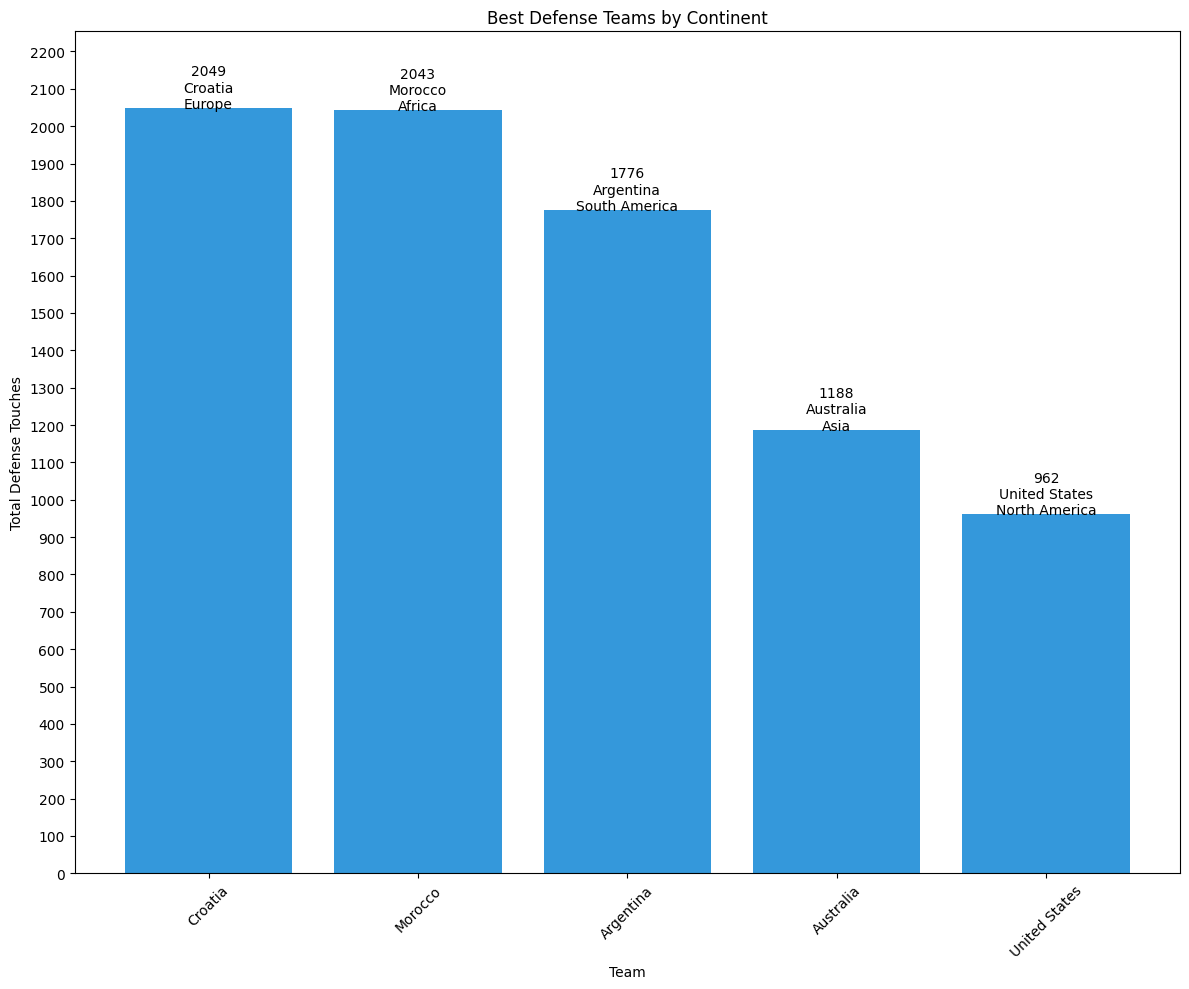

The team with the best defense is Croatia with 2049 defensive touches.


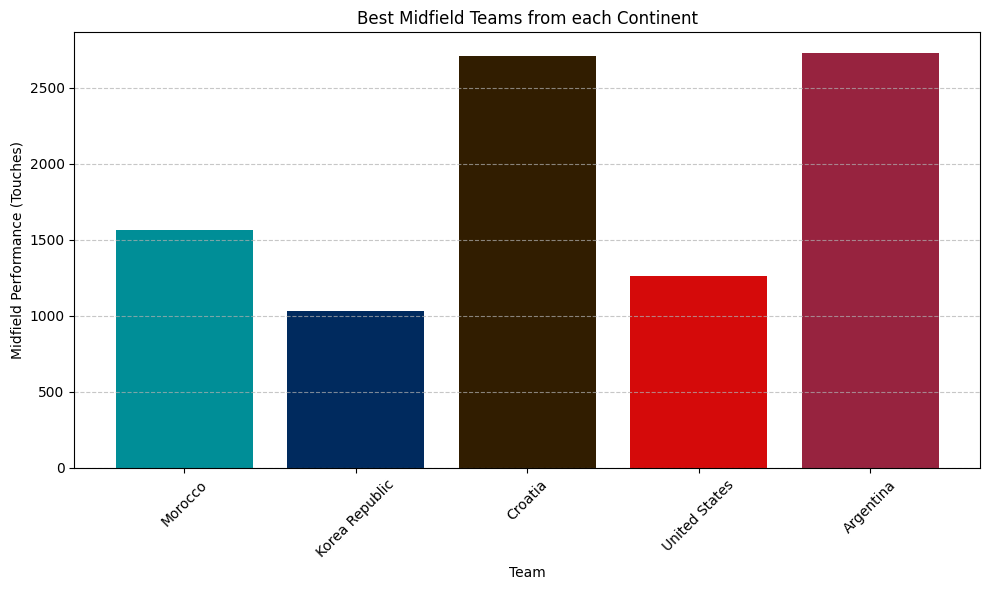

Team with Most Midfield Touches: Argentina
Number of touches:  2727


In [4]:
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class WorldCupDataAnalysis():
    def __init__(self, url='https://fbref.com/en/comps/1/possession/World-Cup-Stats#stats_possession::none'):
        self.data = None  # Stores the dataframe with the data scrapped from the website
        self.url = url  # Stores the url for the website
        self.ranked_col_names = []  # Stores the column names for which a rank is calculated
        self.team_colors = {'ar':'#97233f',
        'au':'#a71930',
        'be':'#241773',
        'br':'#00338d',
        'cm':'#0085ca',
        'ca':'#0b162a',
        'cr':'#fb4f14',
        'hr':'#311d00',
        'dk':'#041e42',
        'ec':'#002244',
        'en':'#0076b6',
        'fr':'#203731',
        'de':'#03202f',
        'gh':'#002c5f',
        'ir':'#006778',
        'jp':'#e31837',
        'kr':'#002a5e',
        'mx':'#003594',
        'ma':'#008e97',
        'nl':'#4f2683',
        'pl':'#002244',
        'pt':'#d3bc8d',
        'qa':'#0b2265',
        'sa':'#125740',
        'sn':'#000000',
        'rs':'#004c54',
        'es':'#ffb612',
        'ch':'#aa0000',
        'tn':'#002244',
        'us':'#d50a0a',
        'uy':'#0c2340'
        }
        self.continent_map = {
        'Asia': ['Australia', 'Iran', 'Japan', 'Korea Republic', 'Qatar', 'Saudi Arabia'],
        'Africa': ['Cameroon', 'Ghana', 'Morocco', 'Senegal', 'Tunisia'],
        'Europe': ['Belgium', 'Croatia', 'Denmark', 'England', 'France', 'Germany', 'Netherlands', 'Poland', 'Portugal', 'Serbia', 'Spain', 'Switzerland', 'Wales'],
        'North America': ['Canada', 'Costa Rica', 'Mexico', 'United States'],
        'South America': ['Argentina', 'Brazil', 'Ecuador', 'Uruguay']
        }
    def scrape(self, url=None):
        if url is None:
            url = self.url
        page = rq.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        table = soup.find('table')
        df = pd.read_html(str(table))[0]
        # Assuming the table has a multi-level column; adjust as per the actual table structure
        df.columns = df.columns.droplevel(0)
        self.data = df

    def preprocess(self):
        # Split 'Squad' column into 'Code' and 'Squad' based on the first space character
        self.data[['Code', 'Squad']] = self.data['Squad'].str.split(' ', n=1, expand=True)
        # Convert columns to numeric types, except for 'Squad' and 'Code'
        for column in self.data.columns:
            if column not in ['Squad', 'Code']:
                self.data[column] = pd.to_numeric(self.data[column], errors='coerce')


    def rank(self):
        for column in self.data.columns:
            if column not in ['Squad', 'Code']:
                new_col = f"{column}_rank"
                self.ranked_col_names.append(column)  # Storing the original column names
                self.data[new_col] = self.data[column].rank(pct=True)

    def continentBest(self):
        self.data["Continent"] = None
        for index, row in self.data.iterrows():
            for continent, countries in self.continent_map.items():
                if row["Squad"] in countries:
                    self.data.at[index, "Continent"] = continent
                    break

        self.data["overall_rank"] = self.data[[col + "_rank" for col in self.ranked_col_names]].mean(axis=1)
        best_teams = self.data.loc[self.data.groupby("Continent")["overall_rank"].idxmax()]
        return best_teams[['Continent', 'Squad', 'overall_rank']]




    def bestAttack(self):
        return self.data.loc[self.data['Att 3rd'].idxmax()]['Squad']


    def compare_best_attack_by_continent(self):
            # Ensure the Total_Attack_Touches column is present
            if 'Total_Attack_Touches' not in self.data.columns:
                self.data['Total_Attack_Touches'] = self.data['Att 3rd'] + self.data['Att Pen']

            # Assign continent to each team
            self.data["Continent"] = None
            for index, row in self.data.iterrows():
                for continent, countries in self.continent_map.items():
                    if row["Squad"] in countries:
                        self.data.at[index, "Continent"] = continent
                        break

            # Find the best midfield team in each continent
            continent_best_attack = self.data.loc[self.data.groupby('Continent')['Total_Attack_Touches'].idxmax()]

            # Plotting
            fig, ax = plt.subplots(figsize=(10, 6))
            teams = continent_best_attack['Squad']
            scores = continent_best_attack['Total_Attack_Touches']
            continents = continent_best_attack['Continent']

            # Iterate through each team in the best midfield teams DataFrame
            for index, row in continent_best_attack.iterrows():
                # Use the team's code to get the color, default to 'grey' if not found
                team_color = self.team_colors.get(row['Code'].lower(), 'grey')  # Ensure the team code is in the correct case

                # Plot a bar for each team with its midfield performance
                ax.bar(row['Squad'], row['Total_Attack_Touches'], color=team_color)

            ax.set_xlabel('Team')
            ax.set_ylabel('Attack Performance (Touches)')
            ax.set_title('Best Attack Teams from each Continent')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()

            # Identifying the team with the best midfield
            best_mid_team = teams.loc[scores.idxmax()]
            print(f"Team with Most Attack Touches: {best_mid_team}")
            print("Number of touches: ", self.data['Total_Attack_Touches'].max())


    def bestDefense(self):
        return self.data.loc[self.data['Def 3rd'].idxmax()]['Squad']


    def compare_best_defense_by_continent(self):

          # Calculate 'Total_Defense_Touches' for each team

          self.data['Total_Defense_Touches'] = self.data['Def 3rd'] + self.data['Def Pen']

          # Find best defense team by continent and sort them

          best_defense_by_continent = self.data.loc[self.data.groupby("Continent")['Total_Defense_Touches'].idxmax()].sort_values('Total_Defense_Touches', ascending=False)

          # Prepare for Visualization

          plt.figure(figsize=(12, 10))

          # Define a consistent color for all bars

          consistent_color = '#3498db'  # Example color: blue

          # Iterate through each team in the sorted best_defense_by_continent DataFrame

          for index, row in best_defense_by_continent.iterrows():

              plt.bar(row['Squad'], row['Total_Defense_Touches'], color=consistent_color)

              plt.text(row['Squad'], row['Total_Defense_Touches'], f"{row['Total_Defense_Touches']}\n{row['Squad']}\n{row['Continent']}", ha='center')

          plt.xlabel('Team')

          plt.ylabel('Total Defense Touches')

          plt.title('Best Defense Teams by Continent')

          plt.xticks(rotation=45)

          # Adjust the y-axis ticks to increments of 100

          y_max = best_defense_by_continent['Total_Defense_Touches'].max()

          plt.ylim(0, y_max + (y_max * 0.1))  # Add 10% headroom to the y-axis maximum

          plt.yticks(np.arange(0, y_max + 200, 100))  # Set y-ticks to increments of 100

          plt.tight_layout()

          plt.show()

          # Identify the Team with the Best Defense Overall

          best_overall_defense = best_defense_by_continent.iloc[0]  # After sorting, the first row is the best overall

          print(f"The team with the best defense is {best_overall_defense['Squad']} with {best_overall_defense['Total_Defense_Touches']} defensive touches.")

          return best_overall_defense['Squad']



    def bestMidfield(self):
        return self.data.loc[self.data['Mid 3rd'].idxmax()]['Squad']


    def compare_best_mid_by_continent(self):
            # Ensure the Total_Midfield_Touches column is present
            if 'Total_Midfield_Touches' not in self.data.columns:
                self.data['Total_Midfield_Touches'] = self.data['Mid 3rd']

            # Assign continent to each team
            self.data["Continent"] = None
            for index, row in self.data.iterrows():
                for continent, countries in self.continent_map.items():
                    if row["Squad"] in countries:
                        self.data.at[index, "Continent"] = continent
                        break

            # Find the best midfield team in each continent
            continent_best_midfield = self.data.loc[self.data.groupby('Continent')['Total_Midfield_Touches'].idxmax()]

            # Plotting
            fig, ax = plt.subplots(figsize=(10, 6))
            teams = continent_best_midfield['Squad']
            scores = continent_best_midfield['Total_Midfield_Touches']
            continents = continent_best_midfield['Continent']

            # Iterate through each team in the best midfield teams DataFrame
            for index, row in continent_best_midfield.iterrows():
                # Use the team's code to get the color, default to 'grey' if not found
                team_color = self.team_colors.get(row['Code'].lower(), 'grey')  # Ensure the team code is in the correct case

                # Plot a bar for each team with its midfield performance
                ax.bar(row['Squad'], row['Total_Midfield_Touches'], color=team_color)

            ax.set_xlabel('Team')
            ax.set_ylabel('Midfield Performance (Touches)')
            ax.set_title('Best Midfield Teams from each Continent')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            plt.tight_layout()
            plt.show()

            # Identifying the team with the best midfield
            best_mid_team = teams.loc[scores.idxmax()]
            print(f"Team with Most Midfield Touches: {best_mid_team}")
            print("Number of touches: ", self.data['Total_Midfield_Touches'].max())

    def visualizeTeam(self, ax, team_name, var_names=None, color=None):
        if var_names is None:
            var_names = self.ranked_col_names
        if color is None:
            team_code = self.data.loc[self.data['Squad'] == team_name, 'Code'].values[0]
            color = self.team_colors.get(team_code, 'grey')  # Fallback color if not found

        data, color = self.getRanksData(team_name)
        self.__drawRadarChart(ax, data, var_names, color)

    def getRanksData(self, team):
        team_data = self.data.loc[self.data['Squad'] == team]
        ranks_data = team_data[[col + '_rank' for col in self.ranked_col_names]].values.flatten()
        code = team_data['Code'].values[0]
        color = self.team_colors[code]
        return ranks_data, color

    def __drawRadarChart(self, ax, data, var_names, color):
        num_vars = len(var_names)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        # Complete the loop for data
        data = np.concatenate((data, [data[0]]))
        # Ensure the plot is circular by completing the loop for angles
        angles += angles[:1]

        # Here, you should ensure var_names also completes the loop if necessary
        # This step seems to be missing or might need adjustment
        # For example, if var_names is supposed to loop, you might need something like:
        var_names = var_names + [var_names[0]]

        ax.plot(angles, data, color=color, linewidth=1)
        ax.fill(angles, data, color=color, alpha=0.25)
        ax.set_thetagrids(np.degrees(angles), var_names)




# Example usage
FIFA = WorldCupDataAnalysis()
FIFA.scrape()
FIFA.preprocess()
FIFA.rank()






#13a. Best ranked team based on touches
def plot_continent_comparison(attribute):
    best_teams = FIFA.continentBest()
    data = FIFA.data.set_index('Squad').loc[best_teams['Squad']][attribute]

    # Define a list of colors for each column
    colors = ['red', 'orange', 'yellow', 'green', 'blue']

    # Plotting
    plt.figure(figsize=(10, 6))
    data.plot(kind='bar', color=colors)  # Using the specified colors for each column
    plt.title(f'Best Team from each Continent based on {attribute}', fontsize=16)
    plt.xlabel('Team', fontsize=14)
    plt.ylabel(attribute, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




    max_touches_index = FIFA.data['Touches'].idxmax()

    # Locate the corresponding row in the DataFrame
    best_team_row = FIFA.data.loc[max_touches_index]

    # Extract the squad name and the number of touches
    best_team = best_team_row['Squad']
    touches = best_team_row['Touches']

    # Print the result
    print("Team With Most Touches: ", best_team)
    print("Number of touches:", touches)


# Example usage:
plot_continent_comparison('Touches')




#13b display result
FIFA.compare_best_attack_by_continent()


#13c display result
FIFA.compare_best_defense_by_continent()


#13d display result
FIFA.compare_best_mid_by_continent()










